In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

In [7]:
#Read the data using the Unnamed (probably id) as index
#url = 'https://s3.amazonaws.com/drivendata/data/4/public/81e8f2de-9915-4934-b9ae-9705685c9d50.csv'
url = '../src/data/raw/training.csv'
training = pd.read_csv(url, index_col='Unnamed: 0')

labels = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 
          'Sharing', 'Student_Type', 'Use']

numeric = ['FTE', 'Total']

categoric = [ 'Facility_or_Department', 'Function_Description', 
            'Fund_Description', 'Job_Title_Description', 'Location_Description', 
            'Object_Description', 'Position_Extra', 'Program_Description', 'SubFund_Description', 
            'Sub_Object_Description', 
            'Text_1', 'Text_2', 'Text_3', 'Text_4']

## Data cleaning

### Part 1: numeric data
First of all, the numeric columns `FTE` and `Total` must be cleaned. The outliers will be treated as `NaN` values and imputation will be applied to the missing data.

In [8]:
# Remove inconsistent data
training[training['FTE'] < 0] = np.nan
training[training['Total'] < 0] = np.nan

In [9]:
training['FTE'].describe()

count    125849.000000
mean          0.427436
std           0.573810
min           0.000000
25%           0.001078
50%           0.133337
75%           1.000000
max          46.800000
Name: FTE, dtype: float64

In [10]:
training[training['FTE'] < 0]

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1


In [11]:
training['Total'].describe()

count    3.518450e+05
mean     1.696423e+04
std      3.402292e+05
min      0.000000e+00
25%      1.384847e+02
50%      6.696800e+02
75%      4.999610e+03
max      1.297000e+08
Name: Total, dtype: float64

In [12]:
imp = Imputer(strategy="median")

training[numeric] = imp.fit_transform(training[numeric])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
training[numeric].isnull().sum()

FTE      0
Total    0
dtype: int64

### Part 2: Categoric data

The strings must be normalized: symbols removed, all letters to lower case. Then, they can be transformed to numeric data.

In [14]:
for category in categoric:
    training[category] = training[category].str.lower()

In [15]:
#Check if the unique values decrease
training[categoric].nunique(dropna=False)

Facility_or_Department     176
Function_Description       655
Fund_Description           141
Job_Title_Description     3455
Location_Description       352
Object_Description         570
Position_Extra             580
Program_Description        418
SubFund_Description        267
Sub_Object_Description     159
Text_1                    1389
Text_2                     279
Text_3                      35
Text_4                     240
dtype: int64

In [16]:
#Convert columns
training[categoric] = training[categoric].apply(lambda x: x.astype('object'), axis = 0)

In [17]:
training[categoric].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 14 columns):
Facility_or_Department    53186 non-null object
Function_Description      298676 non-null object
Fund_Description          179157 non-null object
Job_Title_Description     272317 non-null object
Location_Description      155504 non-null object
Object_Description        332143 non-null object
Position_Extra            244180 non-null object
Program_Description       280943 non-null object
SubFund_Description       263731 non-null object
Sub_Object_Description    70748 non-null object
Text_1                    251891 non-null object
Text_2                    87431 non-null object
Text_3                    108613 non-null object
Text_4                    53384 non-null object
dtypes: object(14)
memory usage: 45.8+ MB


Before removing symbols, let's take a peek on some values and so we can detect the diferrences later


In [18]:
some_functions = training['Function_Description'].value_counts(normalize=True) > 0.05
some_functions.head(6)

non-project                        True
instruction                        True
unalloc budgets/schools            True
basic (fefp k-12)                 False
employee retirement               False
ela e-teaching sheltered eng      False
Name: Function_Description, dtype: bool

In [19]:
# Remove symbols
'''for category in categoric:
    training[category] = training[category].str.replace(r"[&/\)('\"-.,]","")'''
vec = HashingVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", ngram_range=(1,2))

In [20]:
training['Function_Description'].value_counts(normalize=True).head(6)

non-project                       0.191686
instruction                       0.128882
unalloc budgets/schools           0.055458
basic (fefp k-12)                 0.044473
employee retirement               0.043723
ela e-teaching sheltered eng      0.021093
Name: Function_Description, dtype: float64

In [21]:
training[categoric] = training[categoric].fillna("")

In [22]:
training['Function_Description'].isnull().sum()

0

In [23]:
# Join all text items in a row that have a space in between
text_data = training[categoric].apply(lambda x: " ".join(x), axis = 1)

In [24]:
text_data

134338      general fund teacher-elementary    kindergar...
206341     rgn  gob  (blank)  contractor services undesi...
326408      general purpose school tcher 2nd grade  pers...
364634     unalloc budgets/schools  teacher, short term ...
47683      non-project  teacher, secondary (high)   teac...
229958                                                     
417668      local fund   educational supplies and materi...
126378     non-project  sub manager, food service  distr...
275539     ela s - teaching spanish only  teacher, eleme...
85262      unalloc budgets/schools  teacher,retrd shrt t...
304569                                                     
330504     instruction general fund   supplies  primary ...
84272     position control pools  general purpose school...
64760                                                      
21870      basic (fefp k-12)              conversion cha...
18698     all campus payroll instruction general operati...
169454     basic (fefp k-12)            

In [25]:
hec = HashingVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", norm=None, binary=False,
                                                     ngram_range=(1,2))
hashed_text = hec.fit_transform(text_data)

In [26]:
hashed_df = pd.DataFrame(hashed_text.data)
print(hashed_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866634 entries, 0 to 10866633
Data columns (total 1 columns):
0    float64
dtypes: float64(1)
memory usage: 82.9 MB
None


In [27]:
hashed_df.head()

,0
0,1.0
1,2.0
2,-1.0
3,-1.0
4,1.0


### PCA

In [44]:
#preprocessed_df = pd.concat([training[numeric],hashed_df], axis='columns') 

# Define combine_text_columns()
def combine_text_columns(data_frame):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    text_data = data_frame[categoric]
    
    # Replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[numeric], validate=False)

get_dense = FunctionTransformer(lambda x: x.todense(), validate=False)

pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer',HashingVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", 
                                                    norm=None, 
                                                    binary=False,
                                                    ngram_range=(1,2)) 
                    )
                ]))
             ]
        )),
        ('to_dense', get_dense),
        ('pca', PCA(n_components=2))
    ])

preprocessed_sparse = pl.fit_transform(training)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


MemoryError: 

In [ ]:
preprocessed_sparse

In [40]:
preprocesses_df = pd.DataFrame(preprocessed_sparse.toarray())

MemoryError: 

In [ ]:
preprocessed_df[numeric] = imp.fit_transform(preprocessed_df[numeric])

In [35]:
preprocessed_df.head()

,FTE,Total,0
0,0.133337,669.680000,1.0
1,0.133337,669.680000,2.0
2,0.000000,141.579900,-1.0
3,0.000000,1166.760000,-1.0
4,1.000000,33668.537368,1.0


In [ ]:
cov_matrix = preprocessed_df.corr()

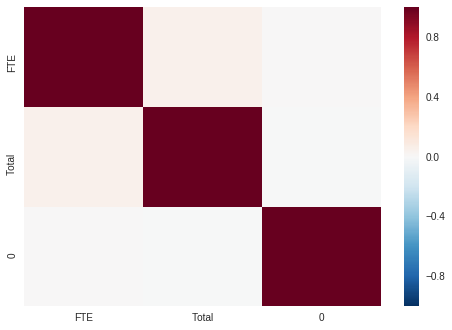

In [42]:
import seaborn as sns
sns.heatmap(cov_matrix)

As we can see, the numeric columns have a 